In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [3]:
import os
import cv2
import numpy as np
import pandas as pd
import datetime
import random
import csv

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import GridSearchCV, train_test_split, RepeatedStratifiedKFold,cross_val_score, KFold, StratifiedKFold
import pyprind
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [4]:
data = []
datetime_object = datetime.date.today()
data  = pd.read_csv('./aug_word_data4.csv')

In [5]:
data.head()

,label,image
0,Bản,0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0....
1,chất,0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0....
2,của,0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0....
3,thành,0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0....
4,công,0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0....


In [6]:
labels = []
images = []
labels = data.iloc[:,0].to_list()
images = data.iloc[:,1].to_list()

In [7]:
print('The number of data',len(labels))

The number of data 110746


In [8]:
max_str_len =   max([len(str(label)) for i,label in enumerate(labels)])
print('Max string length = ', max_str_len)

Max string length =  11


In [9]:
data = [] # This code here for not exploding the RAM

In [10]:
count  = 0
for i,label in enumerate(labels):
    if type(label) == float:
        del labels[i]
        del images[i]
        count +=1
print('The number of invalid data:',count)
print('The number of invalid data left',len(labels))

The number of invalid data: 12
The number of invalid data left 110734


In [11]:
a = images[0]
np.array(a.split(' '),dtype = float)


array([0., 0., 0., ..., 0., 0., 0.])

In [12]:
t  = []
for i, image in enumerate(images):
    image = np.array(image.split(' '),dtype = float)
    t.append(image)
images = []

In [13]:
images = t
t  =[]
print('len images:',len(images))

len images: 110734


In [14]:
images = np.array(images).reshape(-1,128,32,1)

In [15]:
images[0].shape

(128, 32, 1)

# Split data to train_valid_test

In [16]:
X_train, X_valid, y_train, y_valid = train_test_split(images, labels, train_size= 0.85, shuffle = True)
images = []
labels = [] 
print ('\nlen(X_train)',len(X_train))
print ('len(X_valid)',len(X_valid))
print ('\n X_train.shape',X_train.shape)
print ('\n X_valid.shape',X_valid.shape)


len(X_train) 94123
len(X_valid) 16611

 X_train.shape (94123, 128, 32, 1)

 X_valid.shape (16611, 128, 32, 1)


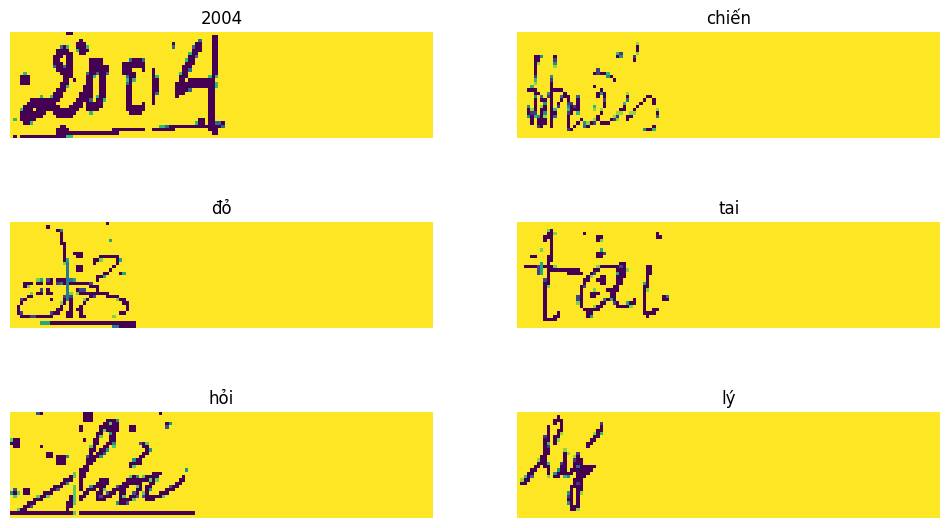

In [17]:
plt.figure(num = 'char',figsize  = (12,7))
for i in range(6):
    rand = random.randint(0,len(X_train))
    plt.subplot(3,2,i+1)
    plt.title(y_train[rand])
    plt.imshow(np.rot90(np.fliplr(np.squeeze(X_train[rand,:,:,]))))
    plt.axis('off')
plt.show()

In [18]:
np.squeeze(X_train[0,:,:,])

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [19]:
alphabets = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYabcdefghijklmnopqrstuvxyzÀÁÂÔÚÝàáâãèéêìíòóôõùúýĂăĐđĩũƒƠơƯưạẢảẤấẦầẩẫậắằẳẵặẹẻẽếỀềỂểễỆệỉịọỏỐốỒồổỗộớờỞởỡợụỦủứừửữựỳỷỹ'
print ('the number of characters:', len(alphabets))
#max_str_len = 15 # max length of input labels
num_of_characters = len(alphabets) + 1 # +1 for ctc pseudo blank
num_of_timestamps = 31  # max length of predicted labels # Đặt num_of_timestamps <= shape(last Dense model)


def label_to_num(label):
    label_num = []
    for ch in label:
        label_num.append(alphabets.find(ch))
        
    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret

the number of characters: 147


In [20]:
num_to_label([21,21,-1])

'LL'

In [21]:
train_y = np.ones([len(X_train), max_str_len]) * -1
train_label_len = np.zeros([len(X_train), 1])
train_input_len = np.ones([len(X_train), 1]) * (num_of_timestamps-2)
train_output = np.zeros([len(X_train)])

In [22]:
for i in range(len(X_train)):
    train_label_len[i] = len(y_train[i])
    train_y[i,0:len(y_train[i])] = label_to_num(y_train[i])

In [23]:
valid_y = np.ones([len(X_valid), max_str_len]) * -1
valid_label_len = np.zeros([len(X_valid), 1])
valid_input_len = np.ones([len(X_valid), 1]) * (num_of_timestamps-2)
valid_output = np.zeros([len(X_valid)])

for i in range(len(X_valid)):
    valid_label_len[i] = len(y_valid[i])
    valid_y[i, 0:len(y_valid[i])]= label_to_num(y_valid[i])  
    

In [31]:
def build_word_model(alphabets, max_str_len, img_width = 128,img_height = 32):
    # Inputs to the model

    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    
    # First conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2),strides = 2, name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        128,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), strides = 2, name="pool2")(x)

    # Third conv block
    x = layers.Conv2D(
        256,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv3",
    )(x)
  

    # Fourth conv block
    x = layers.Conv2D(
        256,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv4",
    )(x)

    x = layers.MaxPooling2D((1, 2), name="pool4")(x)

    # Fifth conv block
    x = layers.Conv2D(
        512,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv5",
    )(x)

    x = layers.BatchNormalization(momentum = 0.8, name="BatchNormalization_1")(x)
    

    # Sixth conv block
    x = layers.Conv2D(
        512,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv6",
    )(x)

    x = layers.BatchNormalization(momentum = 0.8, name="BatchNormalization_2")(x)

    x = layers.MaxPooling2D((1, 2), name="pool6")(x)

    # Seventh conv block
    x = layers.Conv2D(
        512,
        (2, 2),
        activation="relu",
        kernel_initializer="he_normal",
        padding="valid",
        name="Conv7",
    )(x)


    # The number of filters in the last layer is 512. Reshape accordingly before
    # passing the output to the RNN part of the model

    new_shape = (31,512) #Không cần downsampling #Nên coi shape lớp trước

    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)    
    x = layers.Dense(512, activation="relu", name="dense1")(x)
    x = layers.Dense(256, activation="relu", name="dense2")(x)
  
    x = layers.Dropout(0.2)(x)

#     def attention_rnn(inputs):
#         # inputs.shape = (batch_size, time_steps, input_dim)
#         input_dim = int(inputs.shape[2])
#         timestep = int(inputs.shape[1])
#         a = layers.Permute((2, 1))(inputs) #Permutes the dimensions of the input according to a given pattern.
#         a = layers.Dense(timestep, activation='softmax')(a) #// Alignment Model + Softmax
#         a = layers.Lambda(lambda x: keras.backend.mean(x, axis=1), name='dim_reduction')(a)
#         a = layers.RepeatVector(input_dim)(a)
#         a_probs = layers.Permute((2, 1), name='attention_vec')(a)
#         output_attention_mul = layers.multiply([inputs, a_probs], name='attention_mul') #// Weighted Average 
#         return output_attention_mul

#     x = attention_rnn(x)
#     # RNNs
#     x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
#     x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    y_pred = layers.Dense(len(alphabets) + 1 , activation="softmax", name="last_dense")(x) # y pred
    word_model = keras.models.Model(inputs=input_img, outputs=y_pred, name="functional_1")
    return word_model
x  = build_word_model(alphabets = alphabets, max_str_len = max_str_len)
x.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 128, 32, 1)]      0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 128, 32, 64)       640       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 64, 16, 64)        0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 64, 16, 128)       73856     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 32, 8, 128)        0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 32, 8, 256)        295168    
_________________________________________________________________
Conv4 (Conv2D)               (None, 32, 8, 256)       

In [7]:
alphabets = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYabcdefghijklmnopqrstuvxyzÀÁÂÔÚÝàáâãèéêìíòóôõùúýĂăĐđĩũƒƠơƯưạẢảẤấẦầẩẫậắằẳẵặẹẻẽếỀềỂểễỆệỉịọỏỐốỒồổỗộớờỞởỡợụỦủứừửữựỳỷỹ'
import tensorflow as tf
import base64
from tensorflow import keras
import numpy as np
import cv2
import matplotlib.pyplot as plt
model = tf.keras.models.load_model('./word_model_last.h5')
def label_to_num(label):
    label_num = []
    for ch in label:
        label_num.append(alphabets.find(ch))

    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret += alphabets[ch]
    return ret

def readImage(path):
    img = cv2.imread(path,0)
    return img  #(128,32)

def transform_image(image):
    image = (255 - image) * (-10/255)
    return np.around(image)
def preprocess_image(img):

    img = cv2.resize(img, (128, 32), cv2.INTER_CUBIC)
    img = cv2.transpose(img)

    # Transform image
    transformed_image = transform_image(img)
    '''
    Next step must reshape image to (-1,128,32,1 )
    '''
    return transformed_image

def predict(img):
    preds = model.predict(img)
    decoded = tf.keras.backend.get_value(
        tf.keras.backend.ctc_decode(preds, input_length=np.ones(preds.shape[0]) * preds.shape[1],
                                    greedy=True)[0][0])
    prediction = []
    for i in range(decoded.shape[0]):
        prediction.append(num_to_label(decoded[i]))
    return prediction

def ShowPicture(pic,title):
    plt.imshow(pic)
    plt.title(title)
    plt.show()
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')

def base64_to_picture(anh_base64):
    try:
        anh_base64 = np.fromstring(base64.b64decode(anh_base64), dtype=np.uint8)
        anh_base64 = cv2.imdecode(anh_base64, cv2.IMREAD_ANYCOLOR)
    except:
        return None
    return anh_base64

In [18]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from keras.preprocessing import image
from keras.models import load_model
from flask import jsonify

In [20]:
img = image.load_img('./cac.png',color_mode='grayscale')
img = image.img_to_array(img)
img = preprocess_image(img)
img = img.reshape(-1,128,32,1)
prediction = predict(img)

In [21]:
str(prediction)

"['Cặc']"